In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

#### Ejericio 1:

In [8]:
def create_gauss_filter(h: int, w: int, k_size: int =5, sigma: int =2) -> Tuple[np.ndarray, np.ndarray]:
    
    k_1d = cv2.getGaussianKernel(ksize=k_size, sigma=sigma) 
    ker = k_1d * k_1d.T
    
    # Calculate coords to center kernel
    centro_h = h // 2 
    centro_w = w // 2 
    ker_h = ker.shape[0] // 2 
    ker_w = ker.shape[1] // 2 
    inicio_fila = centro_h - ker_h
    fin_fila = inicio_fila + ker.shape[0]
    inicio_col = centro_w - ker_w
    fin_col = inicio_col + ker.shape[1]

    # Center kernel into image size mask
    ker_space_domain = np.zeros((h, w)) 
    ker_space_domain[inicio_fila:fin_fila, inicio_col:fin_col] = ker[:,:]

    # Apply fft
    kernel_furier = np.fft.fft2(ker_space_domain)
 
    return ker_space_domain, kernel_furier

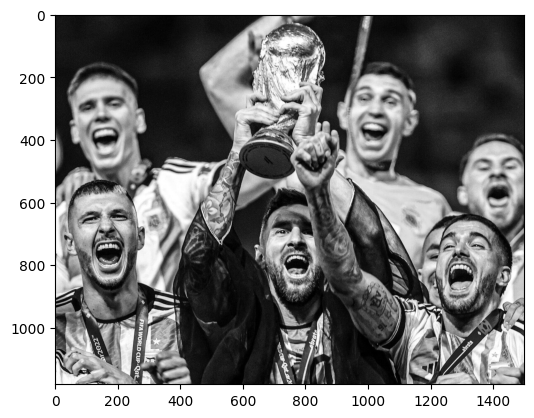

In [5]:
#Cargar imagen en escala de grises
img = cv2.imread('data/arg_2.jpg', cv2.IMREAD_GRAYSCALE)
h, w = img.shape
plt.imshow(img, cmap='gray')

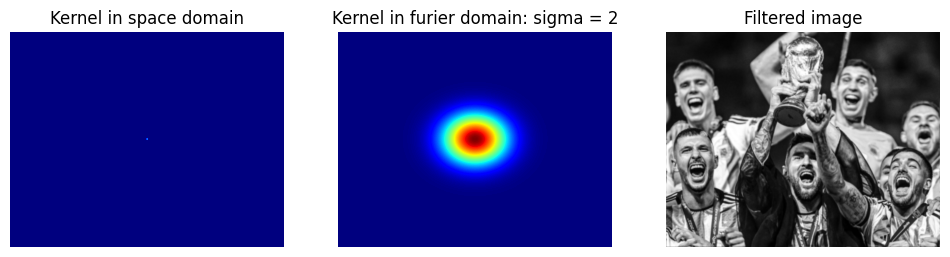

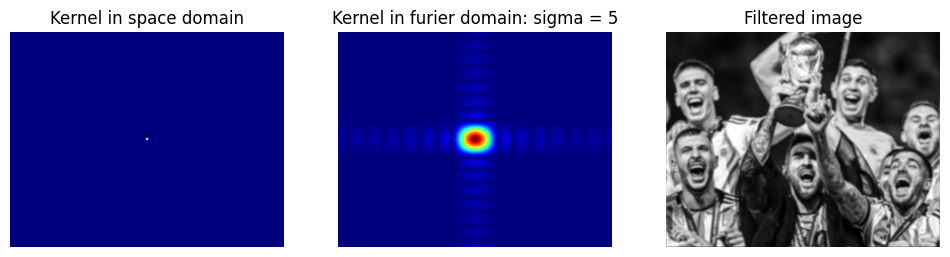

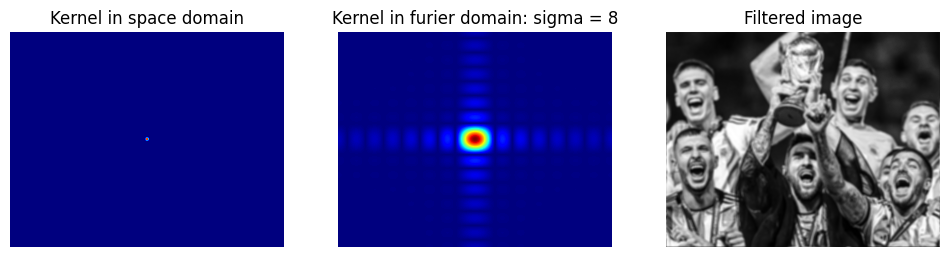

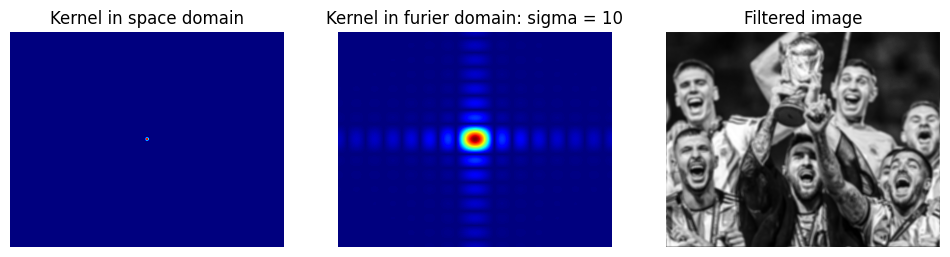

In [33]:
sigma_list = [2, 5, 8, 10]
kernel_size = 15
img_fft = np.fft.fft2(img)

for sigma in sigma_list:
    kernel_space, kernel_fourier = create_gauss_filter(h, w, k_size=kernel_size, sigma=sigma)
    
    img_filtered = img_fft * kernel_fourier
    img_filtered_space = np.fft.ifftshift(np.real(np.fft.ifft2(img_filtered)))

    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].imshow(kernel_space, cmap='jet')
    axes[0].set_title(f'Kernel in space domain')
    axes[0].axis('off')

    shifted_fft = np.fft.fftshift(kernel_fourier)
    axes[1].imshow(np.abs(shifted_fft), cmap='jet')
    axes[1].set_title(f'Kernel in furier domain: sigma = {sigma}')
    axes[1].axis('off')

    axes[2].imshow(img_filtered_space, cmap='gray')
    axes[2].set_title(f'Filtered image')
    axes[2].axis('off')



#### Ejercicio 2: 
Comparar contra GaussianBlur de OpenCV



In [39]:
def calculate_FM(img: np.ndarray) -> float:
    ''' 
    Calculate Image Quality Measure (FM)
    defined in the paper "Image Sharpness Measure for Blurred Images in Frequency Domain "
    '''
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    f = np.fft.fft2(img)
    fc = np.fft.fftshift(f)
    af = np.abs(fc)
    m = np.max(af)
    thres = m/1000
    th = np.sum(f > thres)
    tgrad = th / (img.shape[0] * img.shape[1])
    return tgrad




Difference between two methods is: 0.7807 for sigma: 2
Difference between two methods is: 1.0454 for sigma: 3
Difference between two methods is: 0.4320 for sigma: 4
Difference between two methods is: 0.7282 for sigma: 5
Difference between two methods is: 0.9625 for sigma: 6
Difference between two methods is: 2.0287 for sigma: 7
Difference between two methods is: 1.5608 for sigma: 8
Difference between two methods is: 1.7198 for sigma: 9
Difference between two methods is: 1.3048 for sigma: 10


[Text(0, 0, '2'),
 Text(1, 0, '3'),
 Text(2, 0, '4'),
 Text(3, 0, '5'),
 Text(4, 0, '6'),
 Text(5, 0, '7'),
 Text(6, 0, '8'),
 Text(7, 0, '9'),
 Text(8, 0, '10')]

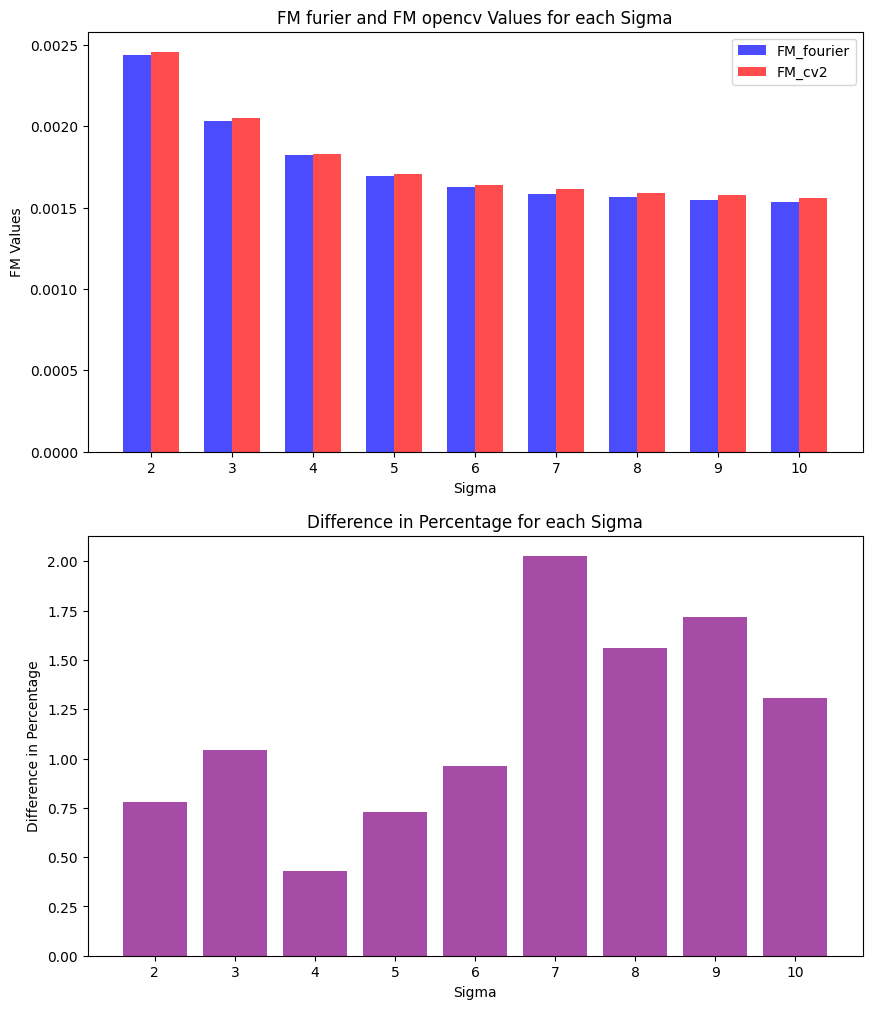

In [40]:
img = cv2.imread('data/arg_2.jpg', cv2.IMREAD_GRAYSCALE)

sigma_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
kernel_size = 15
img_fft = np.fft.fft2(img)

fm_fourier_list = []
fm_opencv_list = []
diff_list = []
for sigma in sigma_list:
    # Filter with our gaussian filter
    kernel_space, kernel_fourier = create_gauss_filter(h, w, k_size=kernel_size, sigma=sigma)
    
    img_filtered = img_fft * kernel_fourier
    img_filtered_w_fourier = np.fft.ifftshift(np.real(np.fft.ifft2(img_filtered)))

    # Fister using opencv gaussian blur: 
    img_filtered_w_space= cv2.GaussianBlur(img, (kernel_size,kernel_size), sigmaX = sigma)

    # Calculate FM score:
    fm_ft = calculate_FM(img_filtered_w_fourier)
    fm_cv2 = calculate_FM(img_filtered_w_space)

    # Save results
    fm_fourier_list.append(fm_ft)
    fm_opencv_list.append(fm_cv2)
    diff = ((fm_cv2-fm_ft)/fm_cv2*100)
    diff_list.append(diff)

    print(f"Difference between two methods is: {diff:.4f} for sigma: {sigma}")

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
n = len(sigma_list)
bar_width = 0.35
index = np.arange(n)
bars1 = ax1.bar(index, fm_fourier_list, bar_width, label='FM_fourier', color='b', alpha=0.7)
bars2 = ax1.bar(index + bar_width, fm_opencv_list, bar_width, label='FM_cv2', color='r', alpha=0.7)

ax1.set_xlabel('Sigma')
ax1.set_ylabel('FM Values')
ax1.set_title('FM furier and FM opencv Values for each Sigma')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(sigma_list)
ax1.legend()

bars_diff = ax2.bar(index, diff_list, color='purple', alpha=0.7)
ax2.set_xlabel('Sigma')
ax2.set_ylabel('Difference in Percentage')
ax2.set_title('Difference in Percentage for each Sigma')
ax2.set_xticks(index)
ax2.set_xticklabels(sigma_list)



Se puede observar que, según la métrica FM, ambos métodos de desenfoque ofrecen resultados similares, ya que la diferencia no supera el 2% para valores de sigma entre 2 y 10.

#### Ejercicio 3: 

Mismo analisis pero con otra de las metricas explicadas en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [37]:
def calculate_tenengrad_score(img: np.ndarray) -> float:
    """
    Calcula el puntaje de enfoque Tenengrad para una imagen dada.
    """
    # Imagen en escala de grises
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calcula los gradientes en las direcciones X e Y utilizando los operadores de Sobel
    Gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Calcula la magnitud del gradiente
    gradient_magnitude = np.square(Gx) + np.square(Gy)

    # El puntaje Tenengrad es la suma de las magnitudes de los gradientes al cuadrado
    tenengrad_score = np.sum(gradient_magnitude)

    return tenengrad_score

Difference between two methods is: -1.3745 for sigma: 2
Difference between two methods is: -2.9852 for sigma: 3
Difference between two methods is: -3.1084 for sigma: 4
Difference between two methods is: -3.2438 for sigma: 5
Difference between two methods is: -3.5444 for sigma: 6
Difference between two methods is: -3.1991 for sigma: 7
Difference between two methods is: -3.4189 for sigma: 8
Difference between two methods is: -3.6130 for sigma: 9
Difference between two methods is: -3.9335 for sigma: 10


[Text(0, 0, '2'),
 Text(1, 0, '3'),
 Text(2, 0, '4'),
 Text(3, 0, '5'),
 Text(4, 0, '6'),
 Text(5, 0, '7'),
 Text(6, 0, '8'),
 Text(7, 0, '9'),
 Text(8, 0, '10')]

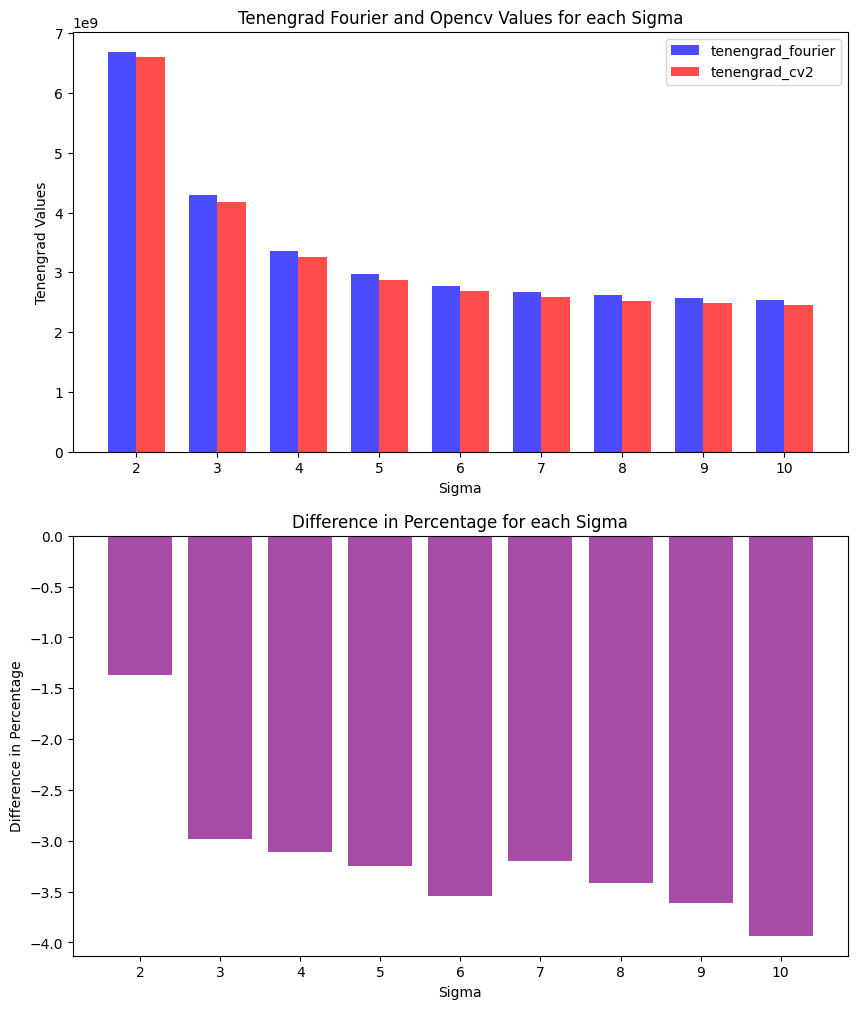

In [42]:
img = cv2.imread('data/arg_2.jpg', cv2.IMREAD_GRAYSCALE)

sigma_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
kernel_size = 15
img_fft = np.fft.fft2(img)

tgrad_fourier_list = []
tgrad_opencv_list = []
diff_list = []
for sigma in sigma_list:
    # Filter with our gaussian filter
    kernel_space, kernel_fourier = create_gauss_filter(h, w, k_size=kernel_size, sigma=sigma)
    
    img_filtered = img_fft * kernel_fourier
    img_filtered_w_fourier = np.fft.ifftshift(np.real(np.fft.ifft2(img_filtered)))

    # Fister using opencv gaussian blur: 
    img_filtered_w_space= cv2.GaussianBlur(img, (kernel_size,kernel_size), sigmaX = sigma)

    # Calculate FM score:
    tgrad_ft = calculate_tenengrad_score(img_filtered_w_fourier)
    tgrad_cv2 = calculate_tenengrad_score(img_filtered_w_space)

    # Save results
    tgrad_fourier_list.append(tgrad_ft)
    tgrad_opencv_list.append(tgrad_cv2)
    diff = ((tgrad_cv2-tgrad_ft)/tgrad_cv2*100)
    diff_list.append(diff)

    print(f"Difference between two methods is: {diff:.4f} for sigma: {sigma}")

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
n = len(sigma_list)
bar_width = 0.35
index = np.arange(n)
bars1 = ax1.bar(index, tgrad_fourier_list, bar_width, label='tenengrad_fourier', color='b', alpha=0.7)
bars2 = ax1.bar(index + bar_width, tgrad_opencv_list, bar_width, label='tenengrad_cv2', color='r', alpha=0.7)

ax1.set_xlabel('Sigma')
ax1.set_ylabel('Tenengrad Values')
ax1.set_title('Tenengrad Fourier and Opencv Values for each Sigma')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(sigma_list)
ax1.legend()

bars_diff = ax2.bar(index, diff_list, color='purple', alpha=0.7)
ax2.set_xlabel('Sigma')
ax2.set_ylabel('Difference in Percentage')
ax2.set_title('Difference in Percentage for each Sigma')
ax2.set_xticks(index)
ax2.set_xticklabels(sigma_list)
